In [ ]:
# import requests
# import pandas as pd
# import time
# from bs4 import BeautifulSoup

# # Step 1: Get all NASDAQ tickers
# def get_nasdaq_tickers():
#     url = "https://old.nasdaq.com/screening/companies-by-name.aspx?letter=0&exchange=nasdaq&render=download"
#     response = requests.get(url)
#     tickers = pd.read_csv(pd.compat.StringIO(response.text))["Symbol"].tolist()
#     return tickers

# # Step 2: Get TradingView rating for each ticker
# def get_tv_rating(ticker):
#     url = f"https://www.tradingview.com/symbols/NASDAQ-{ticker}/technicals/"
#     headers = {"User-Agent": "Mozilla/5.0"}
#     response = requests.get(url, headers=headers)

#     if response.status_code != 200:
#         return None

#     soup = BeautifulSoup(response.text, "html.parser")
#     rating_tag = soup.find("span", {"class": "speedometerSignal-pyzN--tL"})  # TradingView rating tag
#     if rating_tag:
#         return rating_tag.text.strip()
#     return None

# # Step 3: Main script with timer
# def main():
#     print("Fetching all NASDAQ tickers...")
#     tickers = get_nasdaq_tickers()
#     print(f"Found {len(tickers)} tickers.")

#     results = []
#     start_time = time.time()

#     for i, ticker in enumerate(tickers, start=1):
#         rating = get_tv_rating(ticker)
#         results.append({"Ticker": ticker, "TV_Rating": rating})

#         # Progress update every 10 stocks
#         if i % 10 == 0:
#             elapsed = time.time() - start_time
#             avg_time = elapsed / i
#             est_total = avg_time * len(tickers)
#             est_remaining = est_total - elapsed
#             print(f"[{i}/{len(tickers)}] Processed. Elapsed: {elapsed:.1f}s, Remaining: {est_remaining/60:.1f}m")

#     df = pd.DataFrame(results)
#     df.to_csv("nasdaq_tv_ratings.csv", index=False)
#     print("✅ Saved results to nasdaq_tv_ratings.csv")

# if __name__ == "__main__":
#     main()


Fetching all NASDAQ tickers...


2025-09-12 01:19:59,007 - INFO - Test passed for AAPL: Delta=1.00
2025-09-12 01:19:59,027 - INFO - Processing 517 tickers in batches of 500
2025-09-12 01:19:59,028 - INFO - Processing batch 1: 500 tickers
Screening batch:   0%|                                                                         | 0/500 [00:00<?, ?it/s]2025-09-12 01:19:59,245 - WARNING - Failed to get TradingView rating for ABBV: Exchange or symbol not found.
2025-09-12 01:19:59,247 - WARNING - Failed to get TradingView rating for AOS: Exchange or symbol not found.
2025-09-12 01:19:59,247 - WARNING - Failed to get TradingView rating for ABT: Exchange or symbol not found.
2025-09-12 01:19:59,248 - WARNING - Failed to get TradingView rating for AMD: 'RECOMMEND'
2025-09-12 01:19:59,252 - WARNING - Failed to get TradingView rating for AES: Exchange or symbol not found.
2025-09-12 01:19:59,256 - WARNING - Failed to get TradingView rating for ADBE: 'RECOMMEND'
2025-09-12 01:19:59,278 - WARNING - Failed to get TradingView 

Results saved to us_stock_options_screened_2025-09-12_01-20.csv

Top 5 Stocks by Score:
    symbol   price  cost_100_shares tv_rating     score  chance_of_profit
96    CHTR  263.92          26392.0      None  0.673750         89.989365
100    CMG   38.96           3896.0      None  0.670362         88.741751
181    EXE   95.84           9584.0      None  0.635066         85.697730
126   CTRA   24.37           2437.0      None  0.634284         87.300088
143   DXCM   76.00           7600.0      None  0.631859         89.449414


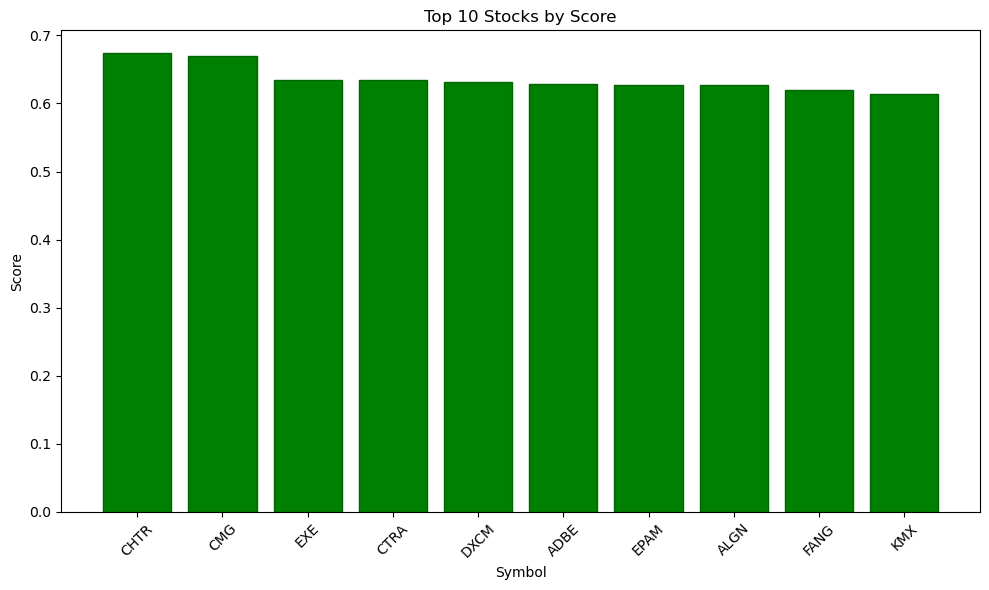

2025-09-12 01:20:32,936 - INFO - Execution time for run_screener_from_csv: 33.93 seconds


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from tradingview_ta import TA_Handler, Interval
from tqdm import tqdm
from scipy.stats import norm
from concurrent.futures import ThreadPoolExecutor, as_completed
import datetime
import time
import logging
import matplotlib.pyplot as plt
import warnings
from tenacity import retry, stop_after_attempt, wait_exponential
import json

# Dependency check
required_libs = ['yfinance', 'pandas', 'numpy', 'tradingview_ta', 'tqdm', 'scipy', 'matplotlib', 'tenacity']
for lib in required_libs:
    try:
        __import__(lib)
    except ImportError:
        print(f"Error: {lib} is not installed. Install it using 'pip install {lib}'")
        exit(1)

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# ------------------------------
# CONFIGURATION
# ------------------------------
CONFIG = {
    'MAX_STOCK_PRICE_TO_OWN_100': None,
    'MAX_PREMIUM_PER_CONTRACT': None,  # Relaxed from 50000
    'EARNINGS_WITHIN_DAYS': 180,         # Relaxed from 90 to 180 days
    'REQUIRE_TV_BUY': False,             # Allow all TV ratings
    'EXPIRY_DAYS_MIN': 0,                # Relaxed from 5 (allow same-day expiries)
    'EXPIRY_DAYS_MAX': 180,              # Relaxed from 90
    'MAX_WORKERS': 8,
    'TOP_N': 50,
    'SCORE_WEIGHTS': {'tv': 0.3, 'upside': 0.3, 'delta': 0.2, 'iv': 0.2},
    'MIN_OPTION_VOLUME': 1,              # Relaxed from 5
    'MIN_OPTION_OPEN_INTEREST': 10,      # Relaxed from 50
    'MIN_DELTA': 0.1,                    # Relaxed from 0.2
    'MAX_DELTA': 0.9,                    # Relaxed from 0.8
    'RISK_FREE_RATE': 0.02,
    'DIVIDEND_YIELD': 0.0,
    'MIN_MARKET_CAP': 100_000_000       # New: Minimum market cap $100M
}

# ------------------------------
# Track filter failures
# ------------------------------
FILTER_FAILURES = {
    'tv_rating': 0,
    'price': 0,
    'earnings': 0,
    'options_empty': 0,
    'options_filtered': 0,
    'api_error': 0,
    'market_cap': 0
}

# ------------------------------
# Timer decorator
# ------------------------------
def timed(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        logging.info(f"Execution time for {func.__name__}: {end - start:.2f} seconds")
        return result
    return wrapper

# ------------------------------
# Get TradingView rating
# ------------------------------
@retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10))
def get_tv_rating(symbol):
    try:
        handler = TA_Handler(symbol=symbol, screener='america', exchange='NASDAQ', interval=Interval.INTERVAL_1_DAY)
        analysis = handler.get_analysis()
        rating = analysis.summary['RECOMMEND']
        score_map = {'STRONG_BUY': 1.0, 'BUY': 0.8, 'NEUTRAL': 0.5, 'SELL': 0.2, 'STRONG_SELL': 0.0}
        return {'rating': rating, 'score': score_map.get(rating, 0.5)}
    except Exception as e:
        FILTER_FAILURES['api_error'] += 1
        logging.warning(f"Failed to get TradingView rating for {symbol}: {str(e)}")
        return {'rating': None, 'score': 0.5}

# ------------------------------
# Fetch Yahoo Finance data
# ------------------------------
def get_yf_data(symbol):
    try:
        stock = yf.Ticker(symbol)
        info = stock.info
        current_price = info.get('regularMarketPrice') or info.get('currentPrice')
        # Price filter
        if not current_price:
            FILTER_FAILURES['price'] += 1
            logging.info(f"Skipping {symbol}: Invalid price")
            return None
        if CONFIG['MAX_STOCK_PRICE_TO_OWN_100'] is not None and current_price * 100 > CONFIG['MAX_STOCK_PRICE_TO_OWN_100']:
            FILTER_FAILURES['price'] += 1
            logging.info(f"Skipping {symbol}: Too expensive (>{CONFIG['MAX_STOCK_PRICE_TO_OWN_100']})")
            return None
        
        # Market cap filter
        market_cap = info.get('marketCap')
        if market_cap is None or market_cap < CONFIG['MIN_MARKET_CAP']:
            FILTER_FAILURES['market_cap'] += 1
            logging.info(f"Skipping {symbol}: Market cap too low or missing")
            return None
        target_price = info.get('targetMeanPrice')
        # Earnings date handling
        earnings_date = None
        if 'earningsDate' in info and info['earningsDate']:
            earnings_date = info['earningsDate']
            if isinstance(earnings_date, list):
                earnings_date = earnings_date[0] if earnings_date else None
            try:
                earnings_date = pd.to_datetime(earnings_date)
                days_until_earnings = (earnings_date - datetime.datetime.now()).days
                if CONFIG['EARNINGS_WITHIN_DAYS'] is not None and days_until_earnings > CONFIG['EARNINGS_WITHIN_DAYS']:
                    FILTER_FAILURES['earnings'] += 1
                    logging.info(f"Skipping {symbol}: Earnings too far ({days_until_earnings} days)")
                    return None
            except (ValueError, TypeError):
                logging.warning(f"Invalid earnings date for {symbol}, treating as None")
                earnings_date = None
        # Options
        options_df = pd.DataFrame()
        options = stock.options
        if not options:
            FILTER_FAILURES['options_empty'] += 1
            logging.info(f"Skipping {symbol}: No options available")
            return None
        option_data = []
        for exp in options:
            days_to_expiry = (pd.to_datetime(exp) - datetime.datetime.now()).days
            # Expiry filter
            if CONFIG['EXPIRY_DAYS_MIN'] is not None and days_to_expiry < CONFIG['EXPIRY_DAYS_MIN']:
                continue
            if CONFIG['EXPIRY_DAYS_MAX'] is not None and days_to_expiry > CONFIG['EXPIRY_DAYS_MAX']:
                continue
            try:
                calls = stock.option_chain(exp).calls
                if calls.empty:
                    continue
                calls['expirationDate'] = exp
                calls['type'] = 'call'
                T = days_to_expiry / 365.0
                if T <= 0:
                    continue
                S = current_price
                strikes = calls['strike'].values
                ivs = np.where(calls['impliedVolatility'].values > 0, calls['impliedVolatility'].values, 0.3)
                d1 = (np.log(S / strikes) + (CONFIG['RISK_FREE_RATE'] - CONFIG['DIVIDEND_YIELD'] + 0.5 * ivs**2) * T) / (ivs * np.sqrt(T))
                calls['delta'] = norm.cdf(d1)
                calls['gamma'] = norm.pdf(d1) / (S * ivs * np.sqrt(T))
                calls['theta'] = -(S * norm.pdf(d1) * ivs) / (2 * np.sqrt(T))
                calls['vega'] = S * norm.pdf(d1) * np.sqrt(T)
                option_data.append(calls)
            except Exception as e:
                logging.warning(f"Error fetching options for {symbol} expiry {exp}: {str(e)}")
                continue
        if option_data:
            options_df = pd.concat(option_data, ignore_index=True)
        return {'symbol': symbol, 'price': current_price, 'target_price': target_price, 'earnings_date': earnings_date, 'options': options_df}
    except Exception as e:
        FILTER_FAILURES['api_error'] += 1
        logging.error(f"Error fetching Yahoo Finance data for {symbol}: {str(e)}")
        return None

# ------------------------------
# Screen a single ticker
# ------------------------------
def screen_ticker(symbol):
    tv = get_tv_rating(symbol)
    if CONFIG['REQUIRE_TV_BUY'] and tv['rating'] not in ['BUY', 'STRONG_BUY']:
        FILTER_FAILURES['tv_rating'] += 1
        logging.info(f"Skipping {symbol}: TV rating {tv['rating']} not BUY/STRONG_BUY")
        return None
    yfdata = get_yf_data(symbol)
    if yfdata is None:
        return None
    # Filter options
    if not yfdata['options'].empty:
        valid_options = yfdata['options'][
            (yfdata['options']['volume'].fillna(0) >= CONFIG['MIN_OPTION_VOLUME']) &
            (yfdata['options']['openInterest'].fillna(0) >= CONFIG['MIN_OPTION_OPEN_INTEREST']) &
            (yfdata['options']['delta'].between(CONFIG['MIN_DELTA'], CONFIG['MAX_DELTA'])) &
            (yfdata['options']['lastPrice'] <= ((CONFIG['MAX_PREMIUM_PER_CONTRACT'] or float('inf')) / 100))
        ]

        if valid_options.empty:
            logging.info(f"Using default option values for {symbol} (no valid options)")
            cop = 50
            iv_score = 0.3
            delta_score = 0.5
            strike = yfdata['price']
            premium = 0
            expiration = None
        else:
            top_call = valid_options.sort_values(by='delta', ascending=False).iloc[0]
            cop = top_call['delta'] * 100
            iv_score = min(top_call['impliedVolatility'] / 0.5, 1.0)
            delta_score = min(max(top_call['delta'], 0), 1)
            strike = top_call['strike']
            premium = top_call['lastPrice']
            expiration = top_call['expirationDate']
    else:
        logging.info(f"Using default option values for {symbol} (no options data)")
        cop = 50
        iv_score = 0.3
        delta_score = 0.5
        strike = yfdata['price']
        premium = 0
        expiration = None
    # Upside
    upside = (yfdata['target_price'] / yfdata['price']) if yfdata['target_price'] else 1.0
    upside_score = min(max((upside - 1) / 1.0, 0), 1)
    # Score
    score = (CONFIG['SCORE_WEIGHTS']['tv'] * tv['score'] +
             CONFIG['SCORE_WEIGHTS']['upside'] * upside_score +
             CONFIG['SCORE_WEIGHTS']['delta'] * delta_score +
             CONFIG['SCORE_WEIGHTS']['iv'] * iv_score)
    return {
        'symbol': yfdata['symbol'],
        'price': yfdata['price'],
        'cost_100_shares': yfdata['price'] * 100,
        'target_price': yfdata['target_price'],
        'earnings_date': yfdata['earnings_date'],
        'tv_rating': tv['rating'],
        'score': score,
        'chance_of_profit': cop,
        'iv': iv_score,
        'delta': delta_score,
        'strike': strike,
        'expiration_date': expiration,
        'premium': premium
    }

# ------------------------------
# Run the screener for a batch of tickers
# ------------------------------
def run_screener_from_csv_batch(tickers):
    results = []
    with ThreadPoolExecutor(max_workers=CONFIG['MAX_WORKERS']) as executor:
        futures = {executor.submit(screen_ticker, t): t for t in tickers}
        for f in tqdm(as_completed(futures), total=len(futures), desc="Screening batch"):
            r = f.result()
            if r:
                results.append(r)
    return pd.DataFrame(results)

# ------------------------------
# Run the screener with batch processing
# ------------------------------
@timed
def run_screener_from_csv(csv_file='all_stocks.csv', batch_size=500):
    try:
        df = pd.read_csv(csv_file)
        if 'Symbol' not in df.columns:
            raise ValueError("CSV file must contain a 'Symbol' column")
        tickers = df['Symbol'].tolist()
    except FileNotFoundError:
        logging.error(f"CSV file {csv_file} not found")
        return pd.DataFrame()
    except pd.errors.EmptyDataError:
        logging.error(f"CSV file {csv_file} is empty")
        return pd.DataFrame()
    logging.info(f"Processing {len(tickers)} tickers in batches of {batch_size}")
    results = []
    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i+batch_size]
        logging.info(f"Processing batch {i//batch_size + 1}: {len(batch)} tickers")
        df_batch = run_screener_from_csv_batch(batch)
        if not df_batch.empty:
            results.append(df_batch)
    if not results:
        print("No stocks passed the screening")
        print("\nFilter Failure Counts:")
        print(json.dumps(FILTER_FAILURES, indent=2))
        return pd.DataFrame()
    df_results = pd.concat(results).sort_values(by='score', ascending=False).head(CONFIG['TOP_N'])
    # Save results
    date_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
    output_file = f"us_stock_options_screened_{date_str}.csv"

    df_results.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")
    # Print summary
    if not df_results.empty:
        print("\nTop 5 Stocks by Score:")
        print(df_results[['symbol', 'price', 'cost_100_shares', 'tv_rating', 'score', 'chance_of_profit']].head())
        # Plot top 10 stocks
        if len(df_results) >= 5:
            top_10 = df_results.head(10)
            plt.figure(figsize=(10, 6))
            plt.bar(top_10['symbol'], top_10['score'], color='green', edgecolor='darkgreen')
            plt.title('Top 10 Stocks by Score')
            plt.xlabel('Symbol')
            plt.ylabel('Score')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
    return df_results

# ------------------------------
# Manual stock check
# ------------------------------
def check_stock(symbol):
    result = screen_ticker(symbol)
    if result:
        df = pd.DataFrame([result])
        print(df[['symbol', 'price', 'cost_100_shares', 'tv_rating', 'score', 'chance_of_profit']])
    else:
        print(f"{symbol} did not pass basic filters (price/earnings/TV/market_cap)")

# ------------------------------
# Test calculations
# ------------------------------
def test_calculations():
    symbol = 'AAPL'
    data = get_yf_data(symbol)
    if data and not data['options'].empty:
        top_call = data['options'].iloc[0]
        assert 0 <= top_call['delta'] <= 1, f"Delta out of range for {symbol}"
        logging.info(f"Test passed for {symbol}: Delta={top_call['delta']:.2f}")

def check_single_stock(ticker, config):
    import yfinance as yf
    
    print(f"\n🔎 Checking {ticker} ...")
    stock = yf.Ticker(ticker)

    try:
        expiry = stock.options[0]  # first expiry
        opt_chain = stock.option_chain(expiry)
        options = opt_chain.calls  # you can also check puts
        options["type"] = "call"
    except Exception as e:
        print(f"❌ Could not fetch options for {ticker}: {e}")
        return

    results = []
    for _, row in options.iterrows():
        score = 0
        notes = []

        # Volume filter
        if row["volume"] >= config["MIN_OPTION_VOLUME"]:
            notes.append("✅ Volume OK")
            score += 1
        else:
            notes.append("❌ Volume Low")

        # Open Interest filter
        if row["openInterest"] >= config["MIN_OPTION_OPEN_INTEREST"]:
            notes.append("✅ OI OK")
            score += 1
        else:
            notes.append("❌ OI Low")

        # Delta filter (if available)
        if "delta" in row and row["delta"] is not None:
            if config["MIN_DELTA"] <= row["delta"] <= config["MAX_DELTA"]:
                notes.append("✅ Delta OK")
                score += 1
            else:
                notes.append("❌ Delta Out of Range")
        else:
            notes.append("⚠️ Delta Not Available")

        # Premium filter
        premium_limit = (config["MAX_PREMIUM_PER_CONTRACT"] or float("inf")) / 100
        if row["lastPrice"] <= premium_limit:
            notes.append("✅ Premium OK")
            score += 1
        else:
            notes.append("❌ Premium High")

        results.append({
            "strike": row["strike"],
            "lastPrice": row["lastPrice"],
            "score": score,
            "notes": "; ".join(notes)
        })

    return results
# ------------------------------
# Example usage
# ----------------------
if __name__ == "__main__":
    test_calculations()
    # df_all = run_screener_from_csv('all_stocks.csv', batch_size=500)
    # check_stock('AAPL')
    run_screener_from_csv()

In [9]:
check_stock("CASI")
res = check_single_stock("CASI", CONFIG)
for r in res[:5]:  # show top 5 strikes
    print(f"Strike {r['strike']} | Price {r['lastPrice']} | Score {r['score']} | {r['notes']}")

2025-08-18 02:57:11,227 - WARNING - Failed to get TradingView rating for CASI: Can't access TradingView's API. HTTP status code: 429. Check for invalid symbol, exchange, or indicators.
2025-08-18 02:57:11,409 - INFO - Skipping CASI: Market cap too low or missing


CASI did not pass basic filters (price/earnings/TV/market_cap)

🔎 Checking CASI ...
Strike 2.5 | Price 0.41 | Score 2 | ✅ Volume OK; ❌ OI Low; ⚠️ Delta Not Available; ✅ Premium OK
Strike 5.0 | Price 0.65 | Score 2 | ✅ Volume OK; ❌ OI Low; ⚠️ Delta Not Available; ✅ Premium OK
Strike 7.5 | Price 0.05 | Score 2 | ✅ Volume OK; ❌ OI Low; ⚠️ Delta Not Available; ✅ Premium OK
